# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

*conda env: ericsson-deep-research*

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client,
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents SDK** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="BingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""
# You are a web search assistant. When provided with a search query, 
# use your web search tool (BingGroundingTool) to retrieve relevant results.

# ALWAYS FORMAT YOUR RESPONSE AS VALID JSON FOLLOWING THIS EXACT STRUCTURE:
# {
#     "subtopic": "the subtopic that was researched",
#     "query": "the actual search query you used",
#     "results": [
#         {
#             "title": "result title",
#             "snippet": "summary of relevant content",
#             "url": "https://example.com/page",
#             "source": "name of the source (optional), if not available, use an empty string",
#             "published_date": "YYYY-MM-DD (optional), if not available, use an empty string"
#         }
#     ]
# }

# DO NOT include any text outside of this JSON structure.
# Ensure all JSON is properly formatted with quotes around keys and string values.
# For any optional fields that are unknown, use null instead of omitting the field.

# Include at least 3 relevant results for each search."""
# )

**OpenAI Agents**

In [6]:
from agents import (
    Agent,
    ModelSettings
)

planner_agent = Agent(
    name="PlannerAgent",
    instructions="""
    You are an expert research planner specializing in creating detailed research plans
    Your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 8 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """,
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=ModelSettings(
        max_tokens=16384,
        temperature=0.3,
    )
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. When given content from search results, "
        "create detailed, information-rich summaries that: \n"
        "1. Extract ALL important facts, statistics, findings, and insights relevant to the subtopic\n"
        "2. Preserve specific numbers, percentages, dates, and technical details whenever present\n"
        "3. Include industry-specific terminology and concepts that add depth to the research\n"
        "4. Maintain the source's key arguments and conclusions\n"
        "5. Provide thorough explanations rather than superficial overviews\n"
        "6. Each summary should be at least 150-250 words to ensure sufficient detail and context\n\n"
        "7. For technical content, preserve methodologies, technical specifications, and implementation details\n"
        "8. For comparative content, maintain all sides of the comparison with their specific attributes\n\n"
        
        "Remember that your summaries serve as the foundation for generating a comprehensive research report. "
        "The quality and depth of the final research report depends directly on how comprehensive your summaries are.\n\n"
        
        "FORMAT YOUR SUMMARY AS:\n"
        "KEY INSIGHTS: [2-3 bullet points of the most critical takeaways]\n\n"
        "[Detailed paragraph-form summary with maximum relevant information]"
    ),
    model=chatModel,
    output_type=str,
    model_settings=ModelSettings(
        max_tokens=16384,
        temperature=0.3,
    )
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with clear hierarchical organization (main sections, subsections, sub-subsections). "
        "Each major section should be rich in data, explanations, and narratives.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"
        
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, "
        "with minimal use of bullet points and maximum depth in paragraph form."
    ),
    model=reasoningModel,
    output_type=ComprehensiveResearchReport
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- NEVER answer the user, NEVER! Do you understand???"
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=reasoningModel,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [7]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

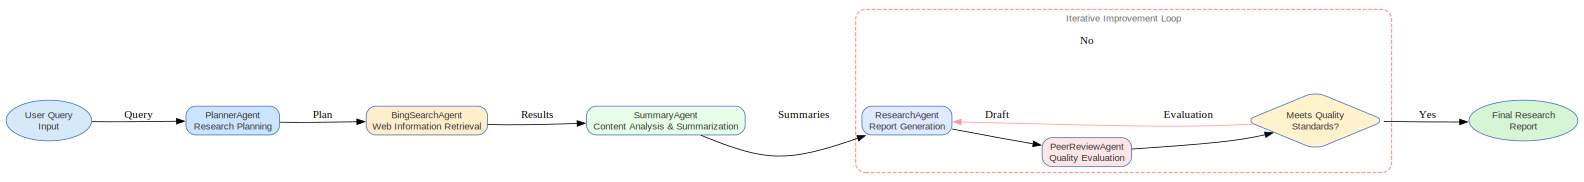

In [8]:
# How to use the module
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [9]:
user_query="What's the latest news in the field of AI? And how what big industries will be affected by it?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [10]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, snippets, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [11]:
from azure.ai.projects.models import MessageRole
from common.utils_search import parse_search_results
from tqdm import tqdm

search_results = []
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}
    
    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: "{query}"
        This is related to subtopic: "{subtopic.subtopic}"
        
        IMPORTANT: Your response must be a valid JSON object matching this structure:
        {{
            "subtopic": "{subtopic.subtopic}",
            "query": "{query}",
            "results": [
                {{
                    "title": "result title",
                    "snippet": "summary of relevant content",
                    "url": "https://example.com/page",
                    "source": "name of the source (optional), if not available, use an empty string",
                    "published_date": "YYYY-MM-DD (optional), if not available, use an empty string"
                }}
            ]
        }}
        """
        
        # Create new thread for each query
        thread = project_client.agents.create_thread()
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role=MessageRole.USER,
            content=formatted_query,
        )

        # Process the run
        run = project_client.agents.create_and_process_run(
            thread_id=thread.id,
            agent_id=bing_search_agent.id
        )
        
        # Get the response text
        messages = project_client.agents.list_messages(thread_id=thread.id)
        if messages.get_last_text_message_by_role(role=MessageRole.agent).text.value:
            text_response = messages.get_last_text_message_by_role(role=MessageRole.agent).text.value
            
            # Parse the text response into structured data
            parsed_results = parse_search_results(text_response)
            
            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "results": parsed_results.results  # This will now be a list of SearchResultItem objects
            })

        # Delete Thread when done
        project_client.agents.delete_thread(thread_id=thread.id)
    
    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 8/8 [03:37<00:00, 27.19s/it]


In [12]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 24

Actually total search queries: 24



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [13]:
mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    task_summaries = []
    citations = []

    for query_result in subtopic_result["queries"]:
        for search_result_item in query_result["results"]:
            content_to_summarize = f"{search_result_item.title}: {search_result_item.snippet}"
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=f"Summarize the following content:\n{content_to_summarize}"
            )
            task_summaries.append(summary_response.final_output)
            
            citations.append(Citation(
                title=search_result_item.title,
                url=search_result_item.url
            ))

    mapped_chunks.append({
        "subtopic": subtopic_result["subtopic"],
        "summaries": task_summaries,
        "citations": [citation.model_dump() for citation in citations]
    })


Summarizing subtopics: 100%|██████████| 8/8 [04:27<00:00, 33.48s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [14]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report"
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [15]:
from openai.types.responses import ResponseFunctionToolCall

if hasattr(final_answer.final_output, "research_report"):
    report = final_answer.final_output.research_report
else:
    # If the last response is PeerReviewFeedback, retrieve the latest ComprehensiveResearchReport from conversation history
    research_reports = [
        item.raw_item.arguments
        for item in final_answer.new_items
        if isinstance(item.raw_item, ResponseFunctionToolCall)
        and '"research_report":' in item.raw_item.arguments
    ]
    
    if research_reports:
        latest_report_json = json.loads(research_reports[-1])
        print(latest_report_json["research_report"])
    else:
        raise ValueError("No comprehensive research report found in conversation history.")


### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [16]:
from IPython.display import display, Markdown
display(Markdown(final_answer.final_output.research_report))

# Introduction

Artificial Intelligence (AI) has witnessed a remarkable evolution over the last decade, transitioning from a niche technology to a driving force behind transformative changes in business, healthcare, education, transportation, and myriad other sectors. Emerging tools and approaches in AI research have led to breakthroughs in natural language processing, computer vision, reinforcement learning, and multimodal systems capable of handling text, images, and audio in unified ways. At its core, AI leverages complex algorithms and large datasets to replicate or augment human cognitive processes, improving upon existing tasks and unlocking entire new classes of applications.

Alongside these leaps in technological capacity, AI has ignited vigorous debates concerning its societal, economic, and ethical implications. As AI models become increasingly capable, organizational leaders around the globe voice both optimism and caution regarding the widespread adoption of AI-powered solutions. Enthusiasm stems from AI’s documented ability to streamline operations—such as predictive analytics to anticipate equipment failures or advanced chatbots to provide customer service any hour of the day—while skepticism emerges when discussing privacy concerns, algorithmic biases, and workforce displacement. Governments, academic institutions, and industry stakeholders are thus tasked with balancing the pursuit of AI innovation with measures that protect individuals and communities.

This report aims to provide a broad yet in-depth overview of AI’s current state and its far-reaching implications in various industries. It begins by examining recent advancements in AI technologies, highlighting developments from cutting-edge generative models to self-generative AI systems. Following that, the report delves into a series of key industries—healthcare, finance, manufacturing, e-commerce, transportation, and education—to explore how AI is transforming the way organizations operate and the strategies they employ to meet market demands. Finally, it addresses vital challenges and ethical considerations that loom over AI implementation, paying particular attention to data privacy, regulatory frameworks, skills shortages, and accountability.

Throughout the discussion, illustrations of AI-driven solutions will be provided, supplemented by references to industry use cases, academic research, and best practices gleaned from multiple domains. The long-form narrative underscores not only the promise but also the complexities inherent in adopting powerful data-driven tools. By offering a structured, comprehensive analysis, this report intends to equip stakeholders with insight into both the potential and the pitfalls of AI in an interconnected 21st-century world.

---

# 1. Recent Advancements in AI Technologies

The year 2023 marked a significant turning point for artificial intelligence, driven largely by improvements in generative modeling, reinforcement learning, and multimodal architectures. Powerful language models have exhibited the capacity to surpass human performance in specialized tasks, handle multilingual prompts, and integrate knowledge from multiple modalities such as text, images, and audio. This section examines the milestones shaping modern AI, including breakthroughs in generative language models, computer vision innovations, and self-generative AI systems.

## 1.1 Generative AI’s Breakout Year

Over the past few years, generative AI has risen to prominence with the success of large-scale language models like OpenAI’s ChatGPT and Google’s Bard. In 2023 alone, generative AI experienced a transformative phase characterized by widespread adoption across industries, from marketing and creative content to customer service operations [1], [2]. Bard, for example, made headlines for its ability to generate multilingual text, supporting global communication and enhancing cross-border collaboration [1]. Similarly, ChatGPT’s capacity for humanlike text generation demonstrated its practicality in drafting, summarizing, and conversational AI tasks, enabling businesses to automate a variety of content-related workflows [2]. Reports indicate that generative models grew increasingly proficient as training datasets expanded in both size and diversity, reinforcing their language comprehension and creativity. This ascendancy also spurred ethical and governance questions concerning the validity of AI-generated content, underscoring the balancing act between harnessing generative AI’s potential and preventing misuse.

## 1.2 Innovation in Multimodal Systems: Gemini and Stable Diffusion

Another frontier in AI advancement lies in multimodal modeling. Gemini, a system developed to handle text, images, and audio as a unified information stream, has shown extraordinary competence in specialized tasks, occasionally outperforming human domain experts [1]. These multimodal systems incorporate advanced feature extraction pipelines that recognize patterns across different data types, thus enabling more holistic decision-making. On a parallel note, computer vision technologies have advanced significantly, exemplified by the release of Stable Diffusion 2.0. This new model generation offers highly detailed and photorealistic images, while providing greater control over artistry and composition [3]. Stable Diffusion’s capacity to generate images from textual prompts with near-photographic realism resonates strongly with fields such as marketing, digital art, and gaming. The incremental refinement of generative systems in vision tasks underscores not only the raw power of contemporary AI techniques but also their broad application potential.

## 1.3 Breakthroughs in Protein Folding and Magnetoreceptive E-Skin

Elsewhere, transformative breakthroughs include AlphaFold’s achievement in high-accuracy protein folding predictions. AlphaFold, developed by DeepMind, revolutionized computational biology by using deep learning to predict protein structures with unprecedented precision [3]. This innovation enables researchers to model complex biomolecular interactions and accelerate drug discovery processes. Further highlighting AI’s breadth, developments such as magnetoreceptive electronic skin (e-skin) illustrate how AI can merge seamlessly with hardware innovations [4]. This e-skin applies magnetoreception to track movement and navigation in previously challenging contexts, including underwater and virtual reality environments, thus creating new vistas for immersive user experiences and advanced sensor technologies.

## 1.4 Emergence of Self-Generative AI

Envisioning an AI landscape in which machines can design other AI systems, Emergence AI has pioneered self-generative artificial intelligence approaches. These meta-learning architectures use neural architecture search to build new models adapted to particular tasks without heavy human oversight [5]. In principle, such systems may drastically reduce development cycles and labor costs, since the AI itself performs critical tasks in data processing, model selection, and hyperparameter tuning. Despite raising novel challenges in interpretability and oversight, self-generative AI expands the horizon of what is technologically and economically feasible. It also prompts serious ethical considerations if AI can innovate in ways that outpace human regulatory controls.

## 1.5 Open-Source Collaboration and Democratization

Alongside individual breakthroughs, open-source AI communities have grown in significance, exemplified by collaborative initiatives such as DeepSeek [6]. Through decentralized architectures and transparent workflows, open-source AI endeavors foster collective advancement, reduce barriers to entry, and expand research participation. Sharing pre-trained models, coding frameworks, and best practices democratizes AI technologies, allowing smaller entities to innovate without needing the extensive resources traditionally reserved for large corporations. Some experts herald open-source as a mechanism for checks and balances to keep proprietary AI approaches accountable, but it also raises questions regarding oversight, security vulnerabilities, and creating robust governance structures. Nevertheless, the momentum gained by open collaboration is critical for sustaining wide adoption and ensuring that AI innovations remain accessible across sectors.

## 1.6 Future Outlook of Generative, Autonomous, and Personalized AI

Projections indicate that by 2025, AI systems will by default incorporate generative capabilities across text, images, and code, thereby revolutionizing content creation processes. Furthermore, autonomous systems, from self-driving vehicles to robotics in logistics, are expected to mature, with improved sensing precision and decision-making under complex real-world parameters [7]. Personalization platforms will likely flourish, offering tailored solutions in healthcare, e-commerce, and educational tools, propelled by deep learning algorithms that rapidly adapt to user-specific preferences [8]. These developments foreshadow an era in which AI shapes not just industry operations but the texture of daily life, presenting opportunities for innovation coupled with concerns about labor displacement, privacy, and ethics.

---

# 2. AI Applications in Healthcare

The healthcare industry exemplifies one of the most transformative domains for AI, particularly as the volume of patient data and the demand for healthcare services expand worldwide. From disease diagnosis and personalized medicine to automated administrative workflows, AI solutions promise efficiency and improved outcomes, though challenges such as data privacy and regulatory compliance persist.

## 2.1 Disease Diagnosis and Patient Data Management

AI-driven techniques are increasingly pivotal in diagnostics and patient data management. Machine Learning (ML) and Natural Language Processing (NLP) analyze unstructured patient data from medical records and imaging scans, turning it into actionable insights [9]. By extracting patterns in imaging data, AI algorithms can detect early indicators of conditions like cancer, diabetic retinopathy, or cardiovascular abnormalities more rapidly than traditional screening processes [10]. Meanwhile, AI simplifies patient data management by structuring clinical notes, synthesizing lab results, and presenting doctors with unified patient profiles. This streamlines decision-making and reduces administrative overload. The World Health Organization’s Global Initiative on Artificial Intelligence for Health (GI-AI4H) accentuates the drive toward ethically conscious and scalable AI solutions that address global health disparities [10].

## 2.2 Conversational AI, Scheduling, and Wearables

Another facet of AI’s influence is the integration of conversational tools and scheduling automation. Chatbots powered by NLP manage early-stage triage, reducing wait times and redirecting patients to the correct specialists [11]. Appointment scheduling benefits from AI-aided platforms that interpret staff availability, patient urgency, and location data, minimizing scheduling conflicts and patient no-shows. Simultaneously, the widespread adoption of wearable devices introduces voluminous real-time patient data—such as heart rate, sleep patterns, and physical activity levels—that AI-driven analytics can incorporate into disease risk assessments [12], [13]. Integrated with Electronic Health Records (EHRs), these devices enable ongoing personalized care and nudge-based interventions to improve lifestyle choices.

## 2.3 Precision Medicine and AI-Enhanced Diagnostics

Precision medicine relies heavily on AI to identify the most effective treatments for patients based on genetic, environmental, and lifestyle factors [14]. Tools like AlphaFold expedite genomic research by mapping protein folding, thus accelerating the drug discovery pipeline. AI-assisted healthcare analytics can also detect clusters of symptoms that suggest readiness for certain treatments, proactively recommending personalized medication regimens. Healthcare professionals increasingly rely on these advanced AI models to reduce subjective biases and deliver evidence-based care promptly. Medical imaging, from CT scans to MRIs, has similarly integrated AI diagnostics for speedier and more accurate detection of anomalies like tumors or fractures [15]. When AI identifies potential issues earlier than human examiners, the likelihood for better patient outcomes rises dramatically.

## 2.4 Administrative Automation and Clinical Chatbots

Beyond direct diagnostics, AI is fundamentally changing administrative workflows. Large healthcare systems, typically burdened by hefty paperwork and manual data entry, deploy AI bots that automate billing, insurance claims, and appointment reminders [16]. This not only lowers administrative costs but also ensures that personnel can focus on clinical tasks. Chatbots now serve as frontline interaction points, addressing frequently asked questions, symptom checks, or medication reminders to patients. Although these tools can significantly reduce burden on clinical staff, they must be carefully validated to confirm reliability and patient safety. The integration of clinical chatbots has proven especially beneficial in resource-limited settings where human providers are scarce, granting continuous care support to remote or underserved populations.

## 2.5 Case Studies in Ophthalmology, Oncology, and Dermatology

AI’s impact is vividly illustrated in medical specialties confronting large volumes of image data. In ophthalmology, AI algorithms screen diabetic retinopathy by analyzing retinal scans and accurately grading disease severity [17]. Oncology benefits from AI-based genomics in identifying genetic mutations that indicate cancer susceptibility or best-fit treatment protocols, while in dermatology, machine learning models detect early signs of melanoma with image recognition that competes with human specialists. These case studies underscore the profound capacity of AI to refine clinical workflows, elevate diagnostic precision, and advance individualized care—though they likewise highlight the need for robust data sets to mitigate biases that might adversely affect certain demographic groups.

## 2.6 Agentic AI for Personalized Diagnostics

Emerging agentic AI systems, capable of autonomous decision-making, are poised to remarkably expand the bounds of healthcare analytics. By integrating advanced algorithms in imaging and lab results interpretation, these AI systems deliver treatment recommendations that adapt to patient health profiles and real-time symptom changes [18]. The personalized diagnostics powered by agentic AI fosters an intersection between big data analytics and precision medicine, giving physicians a clearer lens to preempt disease progression. Additionally, agentic AI can reduce reliance on manual oversight, thereby accelerating clinical workflows. Yet, as the autonomy of AI intensifies, so does the debate around accountability, liability, and the need for human oversight in healthcare settings.

## 2.7 The Dual Impact: Enhanced Efficiency and Ethical Caution

While AI solutions have substantially improved diagnostics, predictive analytics, and administrative efficiencies, the ethical complexities related to health data remain pressing. HIPAA compliance in the United States and GDPR regulations in Europe underscore the strict confidentiality standards for sensitive patient information. AI must thus be developed with robust encryption, anonymization protocols, and limited data retention periods. Additionally, biases in training datasets can propagate inequitable outcomes—for example, if certain ethnic groups are underrepresented in clinical data, AI models might yield suboptimal diagnoses for those populations. Healthcare stakeholders worldwide collaborate on guidelines to ensure that AI deployment furthers equitable access to high-quality care rather than exacerbating systemic disparities.

## 2.8 Path Forward in AI-Driven Healthcare

Going forward, healthcare practitioners, technology providers, and policymakers are expected to deepen collaborations that advance AI adoption. Such partnerships, backed by pragmatic regulatory frameworks and evidence-based trials, may yield breakthroughs in telemedicine, robotics-assisted surgery, and population health analytics [19]. The confluence of big data, affordable sensor devices, and advanced AI algorithms holds the promise of earlier disease detection, streamlined care coordination, and cost savings for already constrained healthcare systems. Nonetheless, success will hinge on forging a balanced interplay between innovation, patient safety, data privacy, and workforce readiness. As AI permeates the healthcare sector, robust guidelines and ethics-based frameworks will be critical for achieving sustainable, inclusive transformations.

---

# 3. AI’s Role in Finance and Banking

The finance sector has embraced AI as a critical tool for automation, data intelligence, and improved risk management. From robotic process automation in back offices to AI-assisted fraud detection on the front lines, financial institutions exploit AI solutions to refine customer care, expedite workflows, and analyze market signals in real time.

## 3.1 Automation and Customer Service Improvements

One hallmark of AI in banking is the automation of manual tasks and routine operations that historically consumed significant labor hours. Robotic Process Automation (RPA) tools allow banks to streamline transaction processing, loan application reviews, and compliance checks with minimal human intervention, reducing operational costs and boosting throughput [20]. At the same time, AI-powered chatbots and virtual assistants cater to customer inquiries around the clock, offering real-time support for account management, bill payments, or financial planning advice. The ramifications for customer satisfaction are immense, as wait times plummet while service consistency rises.

## 3.2 Risk Management and Fraud Detection

Financial institutions increasingly turn to AI-driven risk management platforms that sift through enormous datasets, identifying unusual patterns and anomalies. By processing real-time information on transactions, AI can flag suspicious activities such as money laundering or fraudulent credit card use [20], [21]. Furthermore, machine learning models excel at segmenting customer profiles to forecast default risks, enabling banks to fine-tune loan rates accordingly and preserve capital reserves. This intelligence-driven approach elevates not only the bank’s security posture but also portfolio stability. While conventional rule-based systems detect fraud by matching transactions against known risk parameters, AI’s adaptive capabilities let it detect previously unknown risks.

## 3.3 AI-Enhanced Decision-Making

Beyond risk mitigation, AI aids in more sophisticated financial decision-making. Investment banks harness AI for advanced predictive analytics, enabling them to gauge market sentiments, forecast asset prices, and even automate trading strategies [22]. The synergy of AI with descriptive, diagnostic, and predictive analytics yields robust scenario modeling, allowing decision-makers to test portfolio strategies under various hypothetical market conditions. CFOs also benefit from AI’s ability to optimize cash flow forecasts, identify cost-saving opportunities, and define strategic investment initiatives. By extracting patterns from comprehensive financial data, AI provides a more accurate, data-driven lens on resource allocation.

## 3.4 Evolving Role of CFOs and Operational Efficiency

The World Economic Forum highlights how AI reshapes the responsibilities of Chief Financial Officers (CFOs), particularly through automation and advanced data analytics [23]. CFOs can transition from day-to-day transactional management to strategic initiatives that leverage data insights, mitigating risk and exploring growth opportunities. AI-driven dashboards track KPIs in real time, detect performance deviations, and recommend corrective or proactive measures. Enhanced risk management analytics further empower CFOs to evaluate the financial viability of merges, acquisitions, or expansions. Coupled with robust cybersecurity measures to address new digital vulnerabilities, CFOs must adopt agile frameworks that pivot with shifting market dynamics.

## 3.5 Notable Implementations: COiN and Erica

High-profile examples spotlight the breadth of AI’s impact on banking. JPMorgan Chase’s COiN, short for Contract Intelligence, uses AI to parse legal documents and reduce a task that once required thousands of human hours to seconds [24]. By scanning documents, extracting relevant clauses, and identifying potential compliance red flags, COiN exemplifies how AI can drastically increase operational efficiency. On the consumer-facing side, Bank of America’s Erica chatbot underscores the rise of personalized AI advisors. Erica conversationally assists customers with everyday banking queries, personalized alerts, and budgeting tips, thus creating an engagement layer that transcends conventional banking apps [24]. Such tools herald the next phase of customer-oriented finance, moving beyond transactional relationships to curated recommendations.

## 3.6 Generative AI and Projected Value

Recent analyses suggest generative AI could yield up to $200 billion in incremental value for the global banking sector, thanks to advanced document generation, summarization tools, and product personalization [25]. Whether drafting compliance reports, personalizing marketing content, or generating custom investment strategies, generative AI streamlines knowledge-intensive tasks. The capacity to quickly glean insights from unstructured data drives internal efficiencies and improves the alignment of financial offerings with customer needs. However, caution remains regarding data privacy, security, and veracity, especially when AI-generated artifacts can be intentionally or unintentionally misleading. As a result, banks struggle to adopt generative solutions responsibly, mindful of pertaining regulatory standards.

## 3.7 Personalized Banking and Biometric Security

Beyond automating workflows and generating content, AI has catalyzed a shift toward hyper-personalization. Machine learning algorithms examine customer transaction histories, spending habits, and even geolocation data to propose personalized credit offers and tailor financial insights along one’s spending profile [26]. Meanwhile, AI-based biometric authentication—including voice or facial recognition—bolsters security by purportedly eliminating weaknesses with conventional password systems. HSBC’s voice recognition system, for instance, allows users to verify their identities by speaking, drastically decreasing the risk of unauthorized access [26]. In parallel, Wells Fargo uses AI to refine personalization strategies and enhance security, forging a synergy between user convenience, fraud prevention, and operational efficiency.

## 3.8 Potential Risks and Path Forward

While AI holds great promise in finance, it also poses risks. AI-driven trading bots may magnify market volatility if they collectively respond too rapidly to real-time data or misinformation, precipitating flash crashes [27]. Similarly, cybersecurity threats intensify as criminals attempt to exploit vulnerabilities in AI infrastructures. Regulators acknowledge these issues by encouraging financial institutions to ensure that the adoption of advanced analytics does not subvert system stability or consumer protection. On the horizon, finance is likely to see deeper integration of AI in wealth management, digital assets, and decentralized finance, granting innovative offerings to consumers across socioeconomic tiers. The key challenge is sustaining trust through robust data governance, model interpretability, and ethical guardrails that guide AI’s growth in finance.

---

# 4. AI in Manufacturing and Automation

Automation has always been integral to manufacturing, and AI’s incorporation profoundly amplifies its potential. Today’s “smart factory” uses predictive maintenance, advanced robotics, and digital twins to optimize production lines, reduce costs, and accelerate time-to-market. This section delves into how AI revolutionizes manufacturing processes and supply chain management.

## 4.1 Predictive Maintenance and Quality Control

Manufacturers are increasingly reliant on AI for predictive analytics that evaluates machinery health. Instead of following reactive or routine maintenance schedules, AI-powered systems analyze sensor data to forecast equipment failures before they occur, thus preventing expensive downtime. By examining vibration, temperature, and performance logs, AI models pinpoint anomalies requiring immediate attention [28]. This transformation in maintenance strategies extends equipment lifespan, mitigates disruptions, and saves substantial operational costs. Additionally, in quality control, computer vision and deep learning models are deployed to detect surface defects and dimensional inaccuracies in real time. These systems often outperform human inspections by consistently identifying even minuscule deviations that might compromise product integrity and safety.

## 4.2 Smart Factories and Energy Optimization

The uptake of so-called “smart factories” entails integrating Internet of Things (IoT) devices throughout production lines, generating massive data streamed toward AI systems for analysis. This real-time approach provides operators with immediate insights into production efficiency, allowing dynamic adjustments to optimize throughput [29]. Another core application is energy optimization, in which AI monitors usage patterns and modifies machine operational windows to minimize power costs and reduce overall environmental impact. Such approaches benefit the bottom line by curbing resource wastage while advancing sustainability goals—a priority for manufacturers facing mounting regulatory and consumer scrutiny.

## 4.3 Digital Twins and Mass Customization

Digital twin technology represents a significant leap, with AI simulating and replicating physical processes in real-time virtual models [30]. By coupling data from sensors embedded in machinery with machine learning analytics, these digital twins detect inefficiencies and test hypothetical modifications. The approach expedites new product development cycles and iterative design optimizations. Furthermore, AI fosters mass customization, allowing manufacturers to tailor product models to individual consumer specifications without sacrificing supply chain productivity. By swiftly reconfiguring production lines based on real-time consumer demand forecasts, factories can accommodate localized preferences and short-run manufacturing without major downtimes.

## 4.4 Advanced Robotic Calibration in Semiconductors

Precision is paramount in semiconductor manufacturing, where microscopic variations can derail product performance. AI-driven calibration systems, particularly employing adaptive learning algorithms and robotics, automate the process of aligning hardware for optimal efficiency [31]. Real-time feedback loops measure minute deviations in robotic arms or assembly machines, dynamically adjusting calibration parameters. This drastically cuts time previously spent on manual recalibration, lowers error rates, and reduces material waste—key advantages in an industry that must uphold exacting standards. Automated calibration also supports continuous production, as the system corrects mechanical drifts on the fly, eliminating the need to pause the assembly line.

## 4.5 Japanese Leadership in Automation

Japan’s robust manufacturing heritage and evolving demographic challenges, particularly labor shortages, drive its industries to embrace high-level automation technologies [32]. Firms like YAMAZAKI MAZAK and FANUC lead in the development of collaborative robots (cobots) designed to work alongside human employees. These cobots handle repetitive or physically taxing tasks, thus boosting throughput without compromising worker safety. Concurrently, digital twin systems in Japanese factories refine production processes by simulating equipment performance and exploring “what-if” scenarios. This synergy between advanced robotics and simulation-based insights fosters continuous improvement, ensuring Japan’s manufacturing sector remains competitive.

## 4.6 AI-Driven ERP Systems

Enterprise Resource Planning (ERP) systems benefit extensively from AI-driven enhancements, integrating data analytics for end-to-end visibility across supply chains, production lines, and distribution networks [33]. By collating data from diverse modules—like procurement, inventory, human resources—AI streamlines resource allocation, shortens lead times, and unearths latent inefficiencies. Through advanced machine learning, these systems can generate dynamic forecasts rooted in both historic performance and real-time demand signals, significantly boosting an organization’s resilience and agility in volatile markets. Adopting AI-enabled ERPs becomes increasingly a competitive imperative, particularly as global supply chains endure constant disruption from geopolitical tensions or pandemic-related uncertainties.

## 4.7 Europe’s Ambitious AI Adoption Goals

In Europe, policymakers have set the ambitious target of achieving a 75% AI adoption rate across industries by 2030, highlighting manufacturing and automation as a core focus [34]. This strategic push stems from a desire to maintain global competitiveness, stimulate industrial modernization, and create jobs in AI-related research and development. Efforts concentrate on bridging the knowledge gap among small and medium-sized enterprises (SMEs), providing them with accessible AI pilot programs, financial incentives, and guidelines for responsible AI use. By prioritizing “intelligent engineering,” Europe seeks to combine AI-driven optimization with prudent sustainability measures, from recycling to energy conservation.

## 4.8 Future of Smarter, Sustainable Factories

Looking ahead, AI is projected to infuse automation with greater autonomy, from self-maintaining production lines to self-organizing supply chains, ushering in an era often termed “Industry 4.0.” By 2025, technology stacks tailored explicitly for industrial AI will integrate IoT sensors, edge computing, and deep learning analytics to economize real-time decision-making and reduce reaction latencies [35]. AI will also serve as a linchpin for green manufacturing strategies, carefully balancing operational performance with carbon footprint targets and resource conservation. As more manufacturers deploy AI to enhance agility, the focus expands from cost reduction to broader goals of resilience, customization, and sustainability.

---

# 5. AI’s Influence on Retail and E-commerce

Retail and e-commerce have embraced AI to better predict demand, personalize customer experiences, and increase operational efficiency. The following section explores how AI-driven solutions are reshaping both front-end consumer experiences and back-end supply chain logistics.

## 5.1 Operational Efficiency and Profitability

AI addresses core challenges in retail operations by optimizing inventory management, route planning, and price strategies [36]. Demand forecasting algorithms process historical sales, economic trends, and even external data like weather or local events to predict inventory requirements. These insights mitigate stockouts and unsold surpluses. Similarly, route planning platforms leverage real-time geospatial data to optimize delivery schedules, slash transportation costs, and reduce environmental footprints—a crucial concern for e-commerce reliant on quick shipping. The application of advanced data analytics in these areas not only heightens profitability but also ensures that retailers can respond swiftly to changing consumer preferences.

## 5.2 Personalization and User Engagement

One of the most visible impacts of AI is the personalized shopping experience. Machine learning engines analyze each customer’s browsing patterns, purchase history, and contextual signals to recommend items or services with enhanced relevance [37]. This approach not only elevates user satisfaction but also boosts sales through cross-selling and upselling opportunities. Chatbots and voice-activated assistants further enrich user engagement, offering real-time support and streamlining the purchase funnel. In e-commerce, AI’s personalized recommendations—particularly in fashion, electronics, and subscription services—aid in forging brand loyalty. The result is a user-centric purchasing journey that stands apart from conventional one-size-fits-all retail models.

## 5.3 Fraud Detection, Dynamic Pricing, and Generative Marketing

AI’s role in detecting and preventing fraud has accelerated as e-commerce experiences a surge in digital transactions. Machine learning models that analyze transaction histories and user behaviors can spot suspicious anomalies, reducing false positives and mitigating chargeback costs [38]. Meanwhile, dynamic pricing algorithms update product costs in real time, reflecting competitor moves, seasonality, and shifts in consumer sentiment. Retailers thus sustain competitiveness while safeguarding healthy margins. Generative AI increasingly supports marketing departments by creating high-quality ad copy, personalized email campaigns, and promotional visuals [38]. Although generative AI presents concerns about authenticity, it undoubtedly helps streamline marketing processes and maintain brand consistency.

## 5.4 Augmented Reality and Inventory Management

Augmented reality (AR), backed by AI, is fast gaining traction in e-commerce. AR applications enable consumers to test products virtually—be it furniture in their living rooms or makeup on their faces—bridging the tactile gap inherent to online shopping [39]. By offering visual confirmation of product suitability, AR helps reduce return rates and fosters greater consumer confidence. Alongside these front-end capabilities, back-end logistics benefit from AI’s predictive inventory management. Tools examine real-time sales velocities and consumer purchase patterns to help retailers maintain optimal inventory levels. Automated restocking strategies cut carrying costs, leading to more stable supply chains that remain aligned with consumer demand.

## 5.5 Hyper-Personalization and Physical-Digital Integration

As retailers experiment with bridging physical and virtual experiences, AI underpins “phygital” interactions designed to engage consumers both in-store and online [40]. AI-driven hyper-personalization harnesses data from loyalty apps, usage logs, and geolocation to deliver targeted offers, individualized product suggestions, and even location-specific store layouts. In physical stores, computer vision cameras track inventory in real time to notify staff about low-stock products, while digital signage personalizes promotions to the shopper’s profile. These convergent experiences are especially relevant for brand differentiation, as retailers strive to deliver consistent, seamless journeys that unite the best aspects of digital and physical commerce.

## 5.6 Chatbots, Voice Commerce, and V-Commerce

Customer support chatbots remain a foundational AI use case for retailers aiming to reduce operational overhead and accelerate service. Deployed across websites, social media channels, or mobile apps, these chatbots interpret consumer inquiries and respond instantaneously, guiding users through product searches, returns, or troubleshooting [41]. Voice commerce, or v-commerce, is an emergent trend that allows consumers to interact with systems like Amazon Alexa or Google Assistant to place orders via spoken commands. This hands-free convenience aligns with an increasingly mobile and multitasking consumer base. As v-commerce matures, retailers refine voice-enabled interactions to incorporate natural language understanding, personalization, and frictionless payment flows.

## 5.7 AI-Driven Sustainability Initiatives

As consumer sentiment around sustainability becomes more pronounced, retailers look to AI for improvements in eco-friendly operations. By fine-tuning route optimization, companies lower their carbon footprints, conserve fuel, and reduce last-mile delivery inefficiencies. AI-based analytics also illuminate energy-intensive processes in distribution centers or stores, helping retailers implement greener cooling, lighting, or packaging strategies [42]. Automated inventory management ensures that perishable goods are neither overstocked nor wasted, supporting retail supply chains with minimal environmental impact. Growing consumer preference for environmentally responsible companies further motivates retailers to undertake these AI-driven sustainability measures.

## 5.8 Outlook and Strategic Alignment

AI’s potency in retail and e-commerce extends beyond near-term efficiency gains. Over the next several years, we can expect intensifying adoption of personalization engines, advanced marketing automation, and cross-channel analytics that track consumers from initial contact to repeat buyers [43]. Retailers investing in robust data infrastructures and AI-literate workforces position themselves to leverage emerging technologies—such as generative AI, advanced robotics, or extended reality—to create truly immersive and frictionless shopping environments. Strategic alignment between technology and brand values remains crucial; retailers not only stand to gain from elevated sales figures and customer satisfaction but also face reputational consequences if data privacy and ethical considerations are neglected. Indeed, the ability to combine profitability with socially responsible AI usage will define market leaders in the next evolution of retail.

---

# 6. AI in Transportation and Logistics

Transportation and logistics networks form the backbone of globalized commerce. As demand for fast, reliable delivery of goods has soared, AI offers new ways to optimize route planning, scheduling, capacity utilization, and risk management.

## 6.1 Autonomous Vehicles and Predictive Maintenance

One of the signature AI applications in transportation is autonomous driving, where sensors and machine learning models integrate to guide vehicles without continuous human oversight [44]. From passenger cars to commercial trucking fleets, AI-based control systems interpret real-time camera feeds, LiDAR data, and GPS signals to make split-second decisions. Proponents argue that removing human error can curtail accidents and optimize fuel consumption through strategic driving patterns. Similarly, predictive maintenance in freight transport reduces mechanical failures. By analyzing engine behavior, tire pressure, and telematics, fleet owners preemptively address wear-and-tear, minimizing downtime and increasing vehicle longevity [44], [45].

## 6.2 Smart Parking and Fleet Management

Urban centers grapple with congestion and parking scarcity. AI-driven smart parking solutions identify vacant spots in real time, guiding drivers to open spaces and consequently shrinking traffic bottlenecks [44]. Fleet management further benefits from AI by seamlessly coordinating vehicle dispatches, optimizing load distribution, and tracking drivers’ behavior to ensure safety. In logistics, advanced route planning harnesses real-time data on traffic and weather to orchestrate truck and delivery van schedules. AI can then adapt in the face of unexpected delays or new orders, recalculating the optimal routes and distributing capacity across vehicles. Such dynamic approaches translate into cost savings for logistics providers and elevated service quality for customers.

## 6.3 Minimizing Environmental Footprints and Urban Smog

The transportation sector contributes heavily to carbon emissions, and AI-based solutions are stepping in to mitigate such impacts. By refining route planning, fuel consumption is reduced, thus lowering emissions [46]. Autonomous vehicles, particularly electric ones, may further slash greenhouse gas outputs under optimized driving conditions. AI’s capacity to manage traffic signals and distribution patterns alleviates congestion, decreasing the time vehicles spend idling on city roads. Though the path to fully electrified and autonomous fleets remains lengthy, incremental steps—like predictive maintenance to keep engines efficient—provide immediate environmental benefits.

## 6.4 Accident Detection and Real-Time Analytics

AI’s predictive analytics can significantly enhance road safety. Machine learning algorithms ingest sensor data from vehicles, roadside cameras, and connected infrastructure to detect conditions that elevate accident risk—such as sudden weather changes or unexpected shifts in traffic density [45]. Once anomalies are flagged, relevant authorities can take proactive measures, like altering speed limits or dispatching emergency services. AI also has proven valuable in accident detection and post-accident analytics, helping investigators understand root causes and glean insights to prevent reoccurrence. The advantage stems from AI’s ability to evaluate large datasets swiftly and uncover correlations that might elude conventional analyses.

## 6.5 Real-World Logistics Applications and Efficiency Gains

Major e-commerce and shipping giants demonstrate AI’s potential in logistics. Amazon’s warehouses employ robots and AI to elevate picking efficiency, merging real-time order data with optimal item retrieval strategies [47]. UPS uses an advanced route-optimization system called ORION, saving millions of gallons of fuel and reducing driving miles by algorithmically charting the shortest routes [48]. These real-world examples validate AI’s impact on operational cost reduction, streamlined deliveries, and the capacity to handle spikes in demand—particularly relevant for peak seasons and global surges in e-commerce. Additional applications extend to cold chain management, in which AI monitors perishables en route, ensuring goods arrive in prime condition.

## 6.6 AI Tools in Supply Chain Management

A variety of software platforms—Blue Yonder, IBM Supply Chain, and others—offer predictive analytics to enhance transparency and orchestrate complex supply chains [49]. They consolidate data from multiple nodes, like suppliers, transport providers, and distribution centers, to create a shared view of inventory and shipping statuses. By applying ML algorithms to sales forecasts and historical disruptions, these platforms recommend dynamic ordering, rerouting shipments to circumvent bottlenecks, and optimizing loads for cost efficiency [50]. The result is improved supply chain resilience, enabling better management of shocks like extreme weather events or spikes in consumer demand. Meanwhile, real-time IoT data feeds from cargo containers track temperature, humidity, and location, ensuring product quality over long hauls.

## 6.7 Regulatory and Ethical Complexities

Autonomous driving triggers vexing debates regarding accountability: if an AI-powered car malfunctions and endangers lives, do blame and legal liability accrue to the manufacturer, operator, or software developer? Although some jurisdictions have begun drafting regulations for self-driving vehicles, guidelines remain incomplete, particularly for cross-border trucking routes [51]. Data privacy also stands as a prominent concern, since telematics and onboard sensors gather enormous amounts of driver and passenger information. Ethical conundrums intensify when these data-driven systems expand into public transit or aerial transportation. The impetus is on regulators to partner with industry in clarifying liability frameworks, ensuring robust security measures, and mitigating algorithmic biases.

## 6.8 Toward Fully Autonomous Logistics Networks

Looking to the future, AI experts project a gradual convergence towards fully autonomous logistics. Drone deliveries, driverless trucks, and automated loading docks may collectively reduce labor expenses and accelerate shipping times. Already, pilot projects for drone-based medical supply delivery in remote regions demonstrate the power of advanced autonomy for critical outcomes. As technological maturity deepens and regulatory frameworks take shape, integrated, end-to-end AI networks could make supply chains more transparent and agile. Nonetheless, full reliance on AI for transportation warrants rigorous testing, fail-safes, and cross-industry partnerships to refine standard protocols. The ultimate challenge remains ensuring that efficiency gains do not sideline essential human judgment or disregard sustainable resource usage.

---

# 7. AI’s Impact on Education and Learning

Digital transformation in education has been catalyzed by AI, which offers personalized learning, administrative simplification, and real-time analytics. School systems, universities, and vocational training programs all have begun to leverage AI to enhance accessibility and cater to diverse learner profiles.

## 7.1 Personalized and Adaptive Learning

A core strength of AI in education lies in adaptive learning platforms. Employing machine learning, these platforms analyze each learner’s progress, past performance, and preferences, tailoring content difficulty and delivery pace [52]. By pinpointing individual gaps, adaptive systems direct students toward supplementary resources, ensuring that advanced learners remain challenged while slower-paced learners receive additional reinforcement. This personalized approach has been implemented in massive open online courses (MOOCs), K-12 digital classrooms, and higher education, yielding improvements in learner retention and outcomes.

## 7.2 Expanded Accessibility and Inclusivity

AI-driven tools significantly expand education for marginalized or differently abled learners. For instance, text-to-speech solutions assist visually impaired students by reading digital content aloud, while automated transcription services benefit those with hearing impairments [53]. Natural Language Processing helps create real-time language translations, broadening access in multilingual classrooms. By bridging geographical, sensory, and linguistic barriers, AI fosters inclusivity, making high-quality learning experiences available to broader demographics—particularly in remote or low-resource settings.

## 7.3 Virtual Tutors, Automated Grading, and Course Management

From chatbots offering on-demand clarifications to sophisticated tutoring systems for complex subjects like mathematics or coding, virtual AI tutors have emerged as practical companions for learners outside classroom hours [54]. Meanwhile, educational institutions deploy AI solutions to reduce administrative chores. Automated grading tools, though still refining their capacity to evaluate open-ended essays, handle multiple-choice tests or short answers with considerable reliability. Similarly, intelligent course management systems structure lesson plans, orchestrate scheduling, and compile performance analytics to guide instructors’ curriculum improvements.

## 7.4 AI-Powered Learning Platforms

Commercial and open-source AI-powered platforms centralize course content, integrate interactive assessments, and track learners’ metrics. These platforms rely on personalization algorithms to recommend modules based on a learner’s track record or goals [55]. In corporate training contexts, they adapt content to match the role-specific requirements of employees, accelerating skill acquisition and bridging knowledge gaps. The immediate feedback loops offered by AI-based quizzes and simulations enhance learner engagement and retention. Over time, aggregated analytics on learner performance guide educators in iterative improvements and help organizations pinpoint capability deficits.

## 7.5 Vocational Education and Haptic Interfaces

AI’s reach is not limited to formal academic routes; vocational and technical training also benefits from advanced solutions. Haptic interfaces integrated with AI offer tactile feedback for practical skill-building in lab environments [56]. This technology is especially beneficial for learners with mobility issues, enabling them to practice tasks that replicate real-world scenarios in safe, controlled conditions. Combined with augmented or virtual reality modules, these AI-based simulators speed skill acquisition, reduce training costs, and scale instruction to accommodate more students simultaneously.

## 7.6 Educators’ Evolving Role

As AI systems automate repetitive tasks such as content creation or standardized test grading, educators can shift focus to mentoring, critical thinking development, and fostering creativity in learners [57]. They become facilitators and curators of digital resources, rather than solely content deliverers. The skill profile for educators also evolves; familiarity with AI software, data interpretation, and professional judgment regarding AI recommendations become integral. The transformation is especially pronounced in vocational and technical education, where teachers guide students’ practical engagements, interpret AI analyses, and emphasize problem-solving in scenarios that AI cannot fully address.

## 7.7 Data Privacy and Equity Concerns

Despite the potential, AI in education isn’t devoid of controversies. Collecting large volumes of student data for algorithmic training raises privacy issues. Stakeholders worry about potential misuse of sensitive information or unexpected profiling that might disadvantage certain student groups. Ethical frameworks and robust data governance policies are essential to strike a balance between beneficial personalization and safeguarding confidentiality. Additionally, AI solutions risk exacerbating educational inequities if they remain accessible primarily to well-funded institutions. Closing the digital divide involves ensuring that the necessary hardware, connectivity, and teacher training resources reach underserved communities.

## 7.8 Future of AI-Enhanced Education

Moving ahead, AI’s influence is slated to deepen as blended learning ecosystems become mainstream. Intelligent tutoring systems may gain agentic qualities, autonomously identifying learners’ psychosocial cues to adapt instructions accordingly. Predictive analytics might help educators gauge upcoming trends in workforce demands, guiding students toward relevant skill sets. However, success hinges on strong policy directives that standardize data handling, maintain transparency, and secure accountability. Given AI’s capacity to democratize education worldwide, robust collaborations among government bodies, academia, and private sector leaders will help ensure that progress in digital pedagogy aligns with inclusivity, ethics, and best educational practices.

---

# 8. Challenges and Ethical Considerations in AI Adoption

“We are building the infrastructure of the future, but we must not forget to establish guardrails,” say AI ethicists. As AI expands into every facet of life, a corresponding need arises to confront issues of bias, accountability, privacy, and regulation.

## 8.1 Algorithmic Bias and Data Quality

Algorithmic bias is a pervasive concern when AI models are trained on datasets lacking representativeness or containing historical prejudices [58], [59]. Consequently, the outputs of these models can inadvertently disadvantage particular demographics—whether in hiring processes, credit scoring, or law enforcement. Ensuring the quality and diversity of training data is paramount. Organizations are urged to implement robust data governance frameworks and conduct continuous bias audits to maintain fairness and transparency. Addressing bias is not a one-time undertaking but an iterative process, spanning model design, deployment, and ongoing performance reviews.

## 8.2 Privacy and Surveillance Worries

The combination of AI with big data intensifies controversies around surveillance and personal privacy [59], [60]. Modern AI techniques thrive on vast datasets that often include sensitive personal information. Without strong regulatory safeguards, such systems risk exposing individuals to data breaches, identity theft, and profiling. Initiatives like the European Union’s GDPR or proposals like the U.S. Algorithmic Accountability Act attempt to ensure minimum protective measures for data usage and user consent [61]. Yet, the rapid innovation in AI can outpace legislative bodies, leaving grey areas that unscrupulous actors can exploit. Balancing innovation with privacy rights remains a central tension in AI discourse.

## 8.3 Accountability and Explainability

AI’s opacity raises another challenge: accountability. When AI handles critical decisions—such as denying a loan or diagnosing a patient—users might question who is responsible if the decision proved erroneous. Traditional legal frameworks struggle to assign liability, especially when multiple parties are involved in data collection, algorithm design, and system implementation [62]. Explainable AI (XAI) has emerged as a technical pursuit and regulatory requirement, enabling stakeholders to understand how and why an AI makes particular inferences. Achieving transparency is crucial for trust, though it must be balanced against the proprietary interests of AI developers.

## 8.4 Environmental Impact

Developing and running large-scale AI models can incur massive energy consumption, contributing to carbon emissions [63]. GPT-like models require substantial computational resources, raising concerns about sustainability. In response, research efforts focus on more energy-efficient training algorithms, specialized hardware that reduces power consumption, and carbon offset programs. Some argue that the gains from AI in optimizing energy usage across other industries can offset these ecological costs. Nevertheless, the environmental impact of advanced AI architectures should be factored into corporate social responsibility strategies and product lifecycle assessments.

## 8.5 Workforce Displacement and Socioeconomic Implications

Automation threatens to displace workers in roles involving repetitive tasks—whether on factory floors, customer service call centers, or data entry positions [64]. Policymakers and corporations grapple with the challenge of bridging skill gaps and ensuring seamless transitions to new AI-augmented employment avenues. Discussions around universal basic income (UBI), re-skilling programs, and mentorship initiatives underscore the broader socioeconomic shifts triggered by AI’s unstoppable march of progress. Critics argue that AI benefits may disproportionately accrue to large organizations, potentially widening income inequality if not carefully balanced with public policies aimed at workforce empowerment.

## 8.6 Ethical AI Frameworks and Regulatory Approaches

Various entities, from tech conglomerates to international bodies like UNESCO, emphasize the need for ethical AI guidelines [65]. These provisions commonly revolve around fairness, transparency, inclusivity, and accountability. High-profile efforts—such as the EU’s ongoing pursuit of an AI Act—manifest attempts to systematically regulate AI based on risk categories, imposing stricter requirements on high-risk use cases like biometric surveillance or critical infrastructure controls [66]. On the global stage, regulatory diversity can be problematic when technologies or data flow across international boundaries. Achieving interoperable, standardized frameworks that encourage creativity while mitigating harm remains an ambitious yet necessary goal.

## 8.7 Potential for Misinformation and Malicious Use

Generative AI, while beneficial for content creation, can also be manipulated to produce disinformation, deep fakes, or spam at scale [67]. Such malicious usage can erode public trust in media and strain democratic institutions. Similarly, AI-driven cybersecurity attacks evolve to become more intelligent and harder to detect. The arms race between developers of secure AI systems and adversaries who exploit them intensifies. The impetus lies on multi-stakeholder cooperation to refine detection capabilities for manipulated media and safeguard digital ecosystems. This includes establishing accountability measures and systematically labeling AI-generated content.

## 8.8 Balancing Innovation and Social Well-Being

Ultimately, the challenge lies in harnessing AI’s transformative power while safeguarding public welfare, economic stability, and human dignity. Blanket restrictions on AI risk stifling beneficial applications, whereas unbridled deployment can lead to exploitation and societal upheaval. As new forms of self-generative AI emerge, governance designs must be proactive and often transnational. Collaboration between policymakers, the tech industry, academia, and civil society is crucial to shape AI that remains attuned to ethical imperatives. In this sense, a carefully balanced approach—one that fosters innovation yet remains unwavering in its commitment to responsible AI—is critical for charting AI’s trajectory in the coming decades.

---

# Conclusion

Across a broad spectrum of industries, artificial intelligence has demonstrated a remarkable ability to improve operational efficiency, streamline decision-making, and deliver innovative products and services. From generative language models augmenting content creation workflows to advanced machine learning algorithms guiding crucial healthcare diagnoses, the real-world implications of AI adoption are vast. Industries such as finance, manufacturing, retail, transportation, and education have integrated AI to gain competitive advantages, automate laborious tasks, and extract insights from enormous volumes of data. Meanwhile, the healthcare domain has witnessed remarkable successes with AI-enabled diagnostics, personalized treatment pathways, and streamlined administrative procedures.

Despite this progress, AI’s upward trajectory is accompanied by legitimate societal, economic, and ethical concerns. Regulatory bodies worldwide are grappling with issues such as privacy breaches, algorithmic biases, workforce transitions, and environmental impacts. Companies and governments must proactively develop guardrails to ensure that technological leaps do not trample human rights, amplify inequalities, or degrade trust in institutions. The future of AI hinges not just on maximizing its potential but also on mitigating its risks and embedding principles of fairness, accountability, and transparency at every level of design and deployment.

Looking ahead, AI is poised to transform how societies operate and how institutions innovate. With advanced multimodal systems, agentic AI, and open-source communities spurring fast-evolving applications, the next few years will likely see a deeper penetration of AI into daily life. Yet the ultimate payoff depends on finding equilibrium—a synergy between progress and responsibility that harnesses AI’s power in ways that uplift individuals, businesses, and communities worldwide.

---

# References

[1] 2023: The Year of AI Breakthroughs, https://iotribune.com/2023-the-year-of-ai-breakthroughs
[2] The state of AI in 2023: Generative AI’s breakout year, https://www.mckinsey.com/2023-generative-ai-breakout-year
[3] Latest Advances in Artificial Intelligence and Machine Learning, https://techlasi.com/latest-advances-in-ai-2023
[4] A Lighter, Smarter Magnetoreceptive Electronic Skin, https://www.sciencedaily.com/releases/2025/03/230327092349.htm
[5] AI That Creates AI: The Next Big Innovation, https://www.msn.com/en-us/news/technology/ai-that-creates-ai-the-next-big-innovation/ar-AA1a4bJx
[6] The Bright Future Of Open-Source AI, https://www.forbes.com/sites/forbesbusinesscouncil/2025/03/21/the-bright-future-of-open-source-ai/
[7] Top Artificial Intelligence Applications | AI Applications 2025, https://www.simplilearn.com/artificial-intelligence-applications
[8] The AI Revolution in 2025: Transforming Industries with Cutting-Edge Technology, https://criticalfutureglobal.com/the-ai-revolution-2025
[9] AI in Healthcare, Where It's Going in 2023: ML, NLP & More, https://healthtechmagazine.net/article/2022/12/ai-healthcare-where-its-going-2023
[10] Global Initiative on AI for Health - WHO, https://www.who.int/initiatives/global-initiative-on-ai-for-health
[11] AI Healthcare Trends in 2023, https://www.forbes.com/sites/forbestechcouncil/2023/01/10/ai-healthcare-trends-in-2023/
[12] 6 ways AI is transforming healthcare, https://www.weforum.org/agenda/2025/03/6-ways-ai-is-transforming-healthcare/
[13] How AI is improving diagnostics and health outcomes, https://www.medicalnewstoday.com/articles/how-ai-is-improving-diagnostics-and-health-outcomes
[14] AI in healthcare: Transformative applications, https://www.healthcareitnews.com/news/ai-healthcare-transformative-applications
[15] Revolutionizing Healthcare: Case Studies of AI Algorithms Transforming the Field of Medicine, https://link.springer.com/article/10.1007/springerlink
[16] Agentic AI Trends in 2025: Navigating the Future of Autonomous Intelligence, https://bestarion.com/agentic-ai-trends-2025
[17] Artificial Intelligence in Medical Imaging and Diagnostics, https://example.com/ai-medical-imaging
[18] How AI Is Transforming The Finance Industry, https://www.forbes.com/sites/kathleenwalch/2024/09/14/how-ai-is-transforming-the-finance-industry/
[19] Artificial intelligence in Finance: a comprehensive review, https://link.springer.com/article/10.1007/s10479-025-05123-9
[20] AI is transforming finance, CFOs say. Here's how, https://www.weforum.org/agenda/2025/03/ai-is-transforming-finance-cfos-say/
[21] AI in Banking in 2025: 5 Main Uses & Tools Explained, https://www.edstellar.com/blog/ai-in-banking
[22] The Future of AI in Banking, https://www.mckinsey.com/industries/financial-services/our-insights/the-future-of-ai-in-banking
[23] How AI is Revolutionizing the Banking Sector, https://www.techradar.com/how-ai-is-revolutionizing-banking
[24] The Benefits And Risks Of AI In Financial Services, https://www.forbes.com/sites/forbesfinancecouncil/2023/09/01/the-benefits-and-risks-of-ai-in-financial-services/
[25] Artificial Intelligence and its Impact on Financial Markets and Financial Stability, https://www.imf.org/en/Publications/WEO/Issues/2024/Artificial-Intelligence-and-Financial-Stability
[26] The Transformative Impact Of AI On Financial Services, https://www.forbes.com/sites/gianlucasidoti/2023/07/08/the-transformative-impact-of-ai-on-financial-services/
[27] The Rise of AI in Manufacturing: 2025 Trends, Tools & Real-World Impact, https://www.authentise.com/blog/ai-in-manufacturing-2025
[28] AI in Manufacturing: The Smart Revolution in Industry, https://www.sigmatechnology.com/blog/ai-in-manufacturing
[29] Artificial Intelligence in Manufacturing Processes, https://www.manufacturing.net/ai-in-processes
[30] Automated Calibration of Robots in Semiconductor Manufacturing, https://techbullion.com/automated-calibration-of-robots-in-semiconductor-manufacturing
[31] Japanese Manufacturers Respond to Needs as Automation Gains Momentum, https://seisanzai-japan.com/timtos-2025-report
[32] Your Competitive Advantage Is at Risk: Is It Time for an ERP?, https://www.myob.com/erp-competitive-advantage
[33] Europe Aims to Reach 75% AI Adoption by 2030, https://www.entrepreneur.com
[34] The Tech Outcomes That Matter for 2025, https://www.gartner.com
[35] AI and Automation in Manufacturing, https://www.manufacturing.net
[36] Artificial Intelligence In Retail: 6 Use Cases And Examples, https://www.forbes.com/sites/sap/2024/04/19/artificial-intelligence-in-retail-6-use-cases-and-examples
[37] Here's how artificial intelligence can benefit the retail sector, https://www.weforum.org/agenda/2023/01/how-ai-benefits-retail-sector/
[38] AI in Retail: Transforming the Customer Experience, https://www.retaildive.com/news/ai-in-retail-transforming-customer-experience/637489/
[39] AI in Ecommerce: Applications, Benefits, and Challenges, https://www.shopify.com/blog/ai-in-ecommerce
[40] Top 30 AI eCommerce Use Cases to Boost Growth in 2025, https://research.aimultiple.com/ai-ecommerce-use-cases/
[41] How Artificial Intelligence is Revolutionizing E-commerce, https://www.forbes.com/sites/forbestechcouncil/2023/08/15/how-artificial-intelligence-is-revolutionizing-ecommerce/
[42] Redefining Retail: How AI Is Transforming the Shopping Experience, https://www.analyticsinsight.net/redefining-retail-how-ai-is-transforming-the-shopping-experience/
[43] How AI, Chatbots & V-Commerce Are Changing Shopping, https://www.4-roads.com/how-ai-chatbots-v-commerce-are-changing-shopping/
[44] AI’s Role in E-Commerce: Enhancing Shopping Experiences, https://www.retail-insights.com/ai-role-in-ecommerce-enhancing-shopping-experiences/
[45] AI in Transportation Industry: Use Cases, Benefits, Challenges and Solutions, https://www.prismetric.com/ai-in-transportation-industry/
[46] AI in Transportation Explained: Benefits and Applications, https://relevant.software/blog/ai-in-transportation-explained/
[47] The Role of AI in Transportation and Logistics, https://www.forbes.com/sites/forbestechcouncil/2024/01/15/the-role-of-ai-in-transportation-and-logistics/
[48] Top 15 Logistics AI Use Cases & Examples for Supply Chain Efficiency, https://research.aimultiple.com/logistics-ai-use-cases/
[49] Top 23 Use Cases and Applications of AI in Logistics in 2025, https://markovate.com/ai-in-logistics/
[50] How AI is Revolutionizing Logistics, https://example.com/ai-logistics-revolution
[51] 10 Best AI Tools for Supply Chain Management, https://www.unite.ai/10-best-ai-tools-for-supply-chain-management/
[52] Succeeding in the AI Supply-Chain Revolution, https://www.mckinsey.com/business-functions/operations/our-insights/succeeding-in-the-ai-supply-chain-revolution
[53] AI-Powered Supply Chains Can Save the World, https://blueyonder.com/blog/ai-powered-supply-chains-can-save-the-world
[54] Artificial intelligence in education: A systematic literature review, https://www.sciencedirect.com/science/article/pii/S0747563220303387
[55] Artificial intelligence in education - UNESCO, https://www.unesco.org/en/artificial-intelligence/education
[56] The Role of AI in Education – Benefits, Use Cases & Examples, https://oyelabs.com/ai-in-education-benefits-use-cases-examples/
[57] Top 17 Best AI-powered learning platforms 2025, https://www.paradisosolutions.com
[58] AI In Education: Personalized Learning Platforms In 2025, https://elearningindustry.com
[59] How AI is transforming learning platforms, https://example.com/ai-learning-platforms
[60] Breaking Barriers: How AI is Creating Unprecedented Access to Vocational Education, https://caqa.com.au/breaking-barriers-how-ai-is-creating-unprecedented-access-to-vocational-education
[61] The New Vocational Educators: How AI is Redefining Teaching in Technical Education, https://caqa.com.au/the-new-vocational-educators-how-ai-is-redefining-teaching-in-technical-education
[62] How AI is Transforming Education, https://example.com/ai-transforming-education
[63] Top 9 ethical issues in artificial intelligence, https://www.geeksforgeeks.org/top-9-ethical-issues-in-artificial-intelligence/
[64] AI and Ethics: 5 Ethical Concerns of AI & How to Address Them, https://www.britannica.com/topic/AI-and-Ethics-5-Ethical-Concerns-of-AI
[65] Top 9 ethical issues in artificial intelligence, https://www.weforum.org/agenda/2016/10/top-9-ethical-issues-in-artificial-intelligence/
[66] The implementation of artificial intelligence in organizations: A structured review, https://www.sciencedirect.com/science/article/pii/S0166361519301894
[67] Challenges in AI Implementation and Solutions, https://www.advisedskills.com/blog/artificial-intelligence-ai/challenges-in-ai-implementation-and-solutions
[68] 6 AI Implementation Challenges And How To Overcome Them, https://elearningindustry.com/6-ai-implementation-challenges-and-how-to-overcome-them
[69] How Global Regulators Are Balancing Innovation And Safety For AI, https://smartforlifereviews.com/how-global-regulators-are-balancing-innovation-and-safety-for-ai
[70] The Future of AI: Gazing into the Crystal Ball of the Next Decade, https://www.winklix.com/the-future-of-ai-gazing-into-the-crystal-ball-of-the-next-decade
[71] Ethical Considerations in AI Governance, https://example.com/ethical-considerations-in-ai-governance


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [17]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To investigate the latest developments in artificial intelligence and analyze its impact on major industries.",
  "aggregated_summaries": [
    {
      "subtopic": "Recent advancements in AI technologies",
      "summaries": [
        "**KEY INSIGHTS:**\n- Generative AI tools like Bard and Gemini have achieved groundbreaking capabilities in multilingual text generation and multimodal tasks, respectively.\n- Gemini, a multimodal AI model, has surpassed human experts in specific domains, marking a significant leap in AI performance and application potential.\n\n**Detailed Summary:**\nThe year 2023 has been pivotal for advancements in artificial intelligence, particularly in the domain of generative AI. Tools such as Bard have demonstrated